In [1]:
# Imports
import csv
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
from albumentations import Compose as AlbCompose, Resize as AlbResize, Normalize as AlbNormalize, HorizontalFlip, RandomBrightnessContrast, GaussianBlur
from segmentation_models_pytorch import DeepLabV3Plus
from IPython.display import display

c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# File paths
model_filepath = 'Exp_2.pth'
csv_filepath = 'Output/Exp_2_Metrics.csv'

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
# Initialize the model architecture
model = DeepLabV3Plus(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=2).to(device)

# Load model state without retraining
def load_model_state(model, filepath=model_filepath):
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        print("Model loaded successfully!")
    else:
        print(f"Model checkpoint '{filepath}' not found.")

# Load the model
load_model_state(model)


C:\Users\Victor\AppData\Local\Temp\ipykernel_13792\3185839564.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=device)


Model loaded successfully!


In [4]:
# Define transformations
def get_transforms(augmentation_type=None):
    base_transforms = [
        AlbResize(height=256, width=256, interpolation=1),
        AlbNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]
    
    augmentations = {
        'Horizontal Flip': HorizontalFlip(p=0.5),
        'Brightness/Contrast': RandomBrightnessContrast(p=0.2),
        'Gaussian Blur': GaussianBlur(blur_limit=(3, 7), p=0.2)
    }
    
    if augmentation_type in augmentations:
        return AlbCompose([augmentations[augmentation_type]] + base_transforms)
    else:
        return AlbCompose(base_transforms)


In [5]:
# Dataset class
class KvasirDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        with open(file_list, 'r') as f:
            self.image_filenames = f.read().splitlines()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.images_dir, self.image_filenames[idx] + '.jpg')).convert("RGB")
        mask = Image.open(os.path.join(self.masks_dir, self.image_filenames[idx] + '.png')).convert("L")

        image_np = np.array(image)
        mask_np = np.array(mask)

        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)
            image, mask = augmented['image'], augmented['mask']

        mask = (mask > 0).astype(np.int64)

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask


In [6]:
# Initialize DataLoaders
images_dir = 'kvasir-instrument/images/'
masks_dir = 'kvasir-instrument/masks/'
train_file_list = 'kvasir-instrument/train.txt'
test_file_list = 'kvasir-instrument/test.txt'

train_loader_no_aug = DataLoader(
    KvasirDataset(images_dir, masks_dir, train_file_list, transform=get_transforms()),
    batch_size=8, shuffle=True
)

augmentation_types = ['Horizontal Flip', 'Brightness/Contrast', 'Gaussian Blur']
train_loaders = {
    aug: DataLoader(
        KvasirDataset(images_dir, masks_dir, train_file_list, transform=get_transforms(augmentation_type=aug)),
        batch_size=8, shuffle=True
    ) for aug in augmentation_types
}

test_loader = DataLoader(
    KvasirDataset(images_dir, masks_dir, test_file_list, transform=get_transforms()),
    batch_size=8, shuffle=False
)


In [7]:
# Load metrics from CSV file
csv_filepath = 'Output/Exp_2_Metrics.csv'
if os.path.exists(csv_filepath):
    metrics_df = pd.read_csv(csv_filepath)
    print(f"Metrics loaded from '{csv_filepath}'.")
    print("Columns in the DataFrame:", metrics_df.columns)
else:
    print(f"No CSV file found at '{csv_filepath}'.")

# Strip trailing spaces from column names
metrics_df.columns = metrics_df.columns.str.strip()


Metrics loaded from 'Output/Exp_2_Metrics.csv'.
Columns in the DataFrame: Index(['Augmentation        ', 'Epoch ', 'Train Loss           ',
       'Test Loss            ', 'Train Accuracy     ', 'Test Accuracy      ',
       'Train Jaccard      ', 'Test Jaccard       ', 'Train Precision    ',
       'Test Precision     ', 'Train Recall       ', 'Test Recall        ',
       'Train Dice         ', 'Test Dice'],
      dtype='object')


In [8]:
# Check if 'Augmentation' column exists
if 'Augmentation' in metrics_df.columns:
    # Calculate and display average metrics for each augmentation type
    average_metrics = metrics_df.groupby("Augmentation").mean().reset_index()
    sorted_results = average_metrics.sort_values(by="Test Accuracy", ascending=False)
    top_4_results = sorted_results.head(4)
    print(top_4_results)
else:
    print("The 'Augmentation' column is not present in the DataFrame.")

           Augmentation  Epoch  Train Loss  Test Loss  Train Accuracy  \
0  Brightness/Contrast     7.0    0.028791   0.043579        0.989262   
1  Gaussian Blur           2.5    0.023381   0.045664        0.990972   
2  Horizontal Flip         7.0    0.041497   0.051981        0.984672   
3  Not_Augmented           4.0    0.071599   0.054853        0.973211   

   Test Accuracy  Train Jaccard  Test Jaccard  Train Precision  \
0       0.987285       0.896433      0.869597         0.949120   
1       0.987113       0.911456      0.868247         0.956005   
2       0.984032       0.856814      0.833861         0.927921   
3       0.980338       0.782975      0.803487         0.885714   

   Test Precision  Train Recall  Test Recall  Train Dice  Test Dice  
0        0.946409      0.941541     0.913447    0.944449   0.928512  
1        0.941105      0.951436     0.916422    0.953080   0.927506  
2        0.948545      0.917156     0.871735    0.920714   0.905388  
3        0.919958      

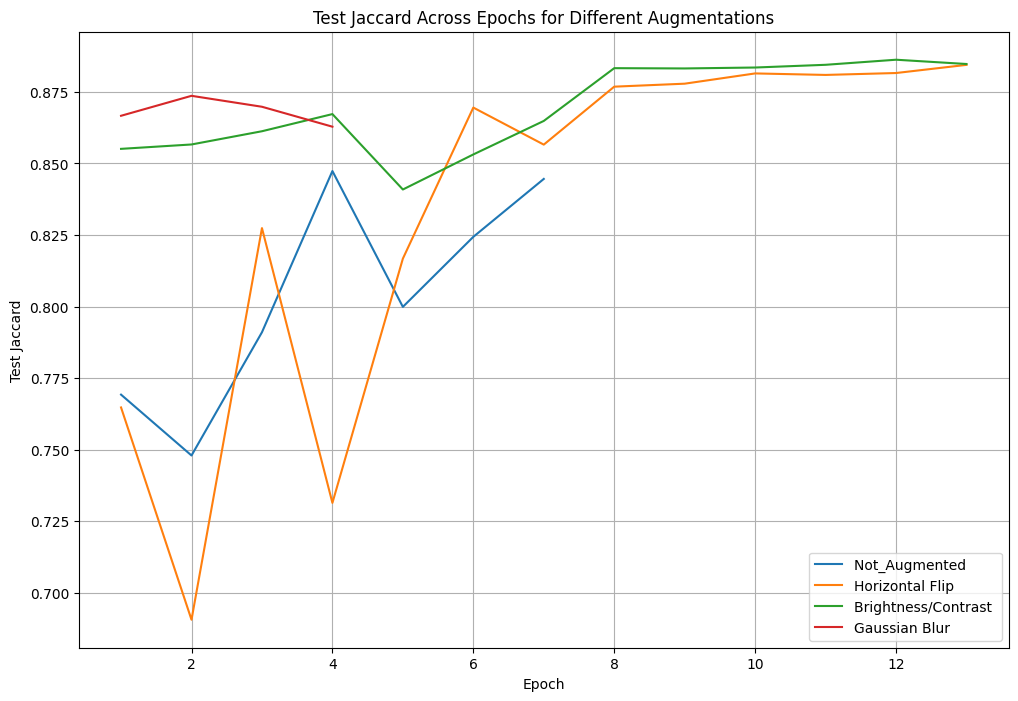

In [9]:
# Plotting Test Jaccard Across Epochs for Different Augmentations
plt.figure(figsize=(12, 8))
for augmentation in metrics_df['Augmentation'].unique():
    augmentation_data = metrics_df[metrics_df['Augmentation'] == augmentation]
    plt.plot(augmentation_data['Epoch'], augmentation_data['Test Jaccard'], label=augmentation)

plt.xlabel('Epoch')
plt.ylabel('Test Jaccard')
plt.title('Test Jaccard Across Epochs for Different Augmentations')
plt.legend()
plt.grid(True)
plt.show()

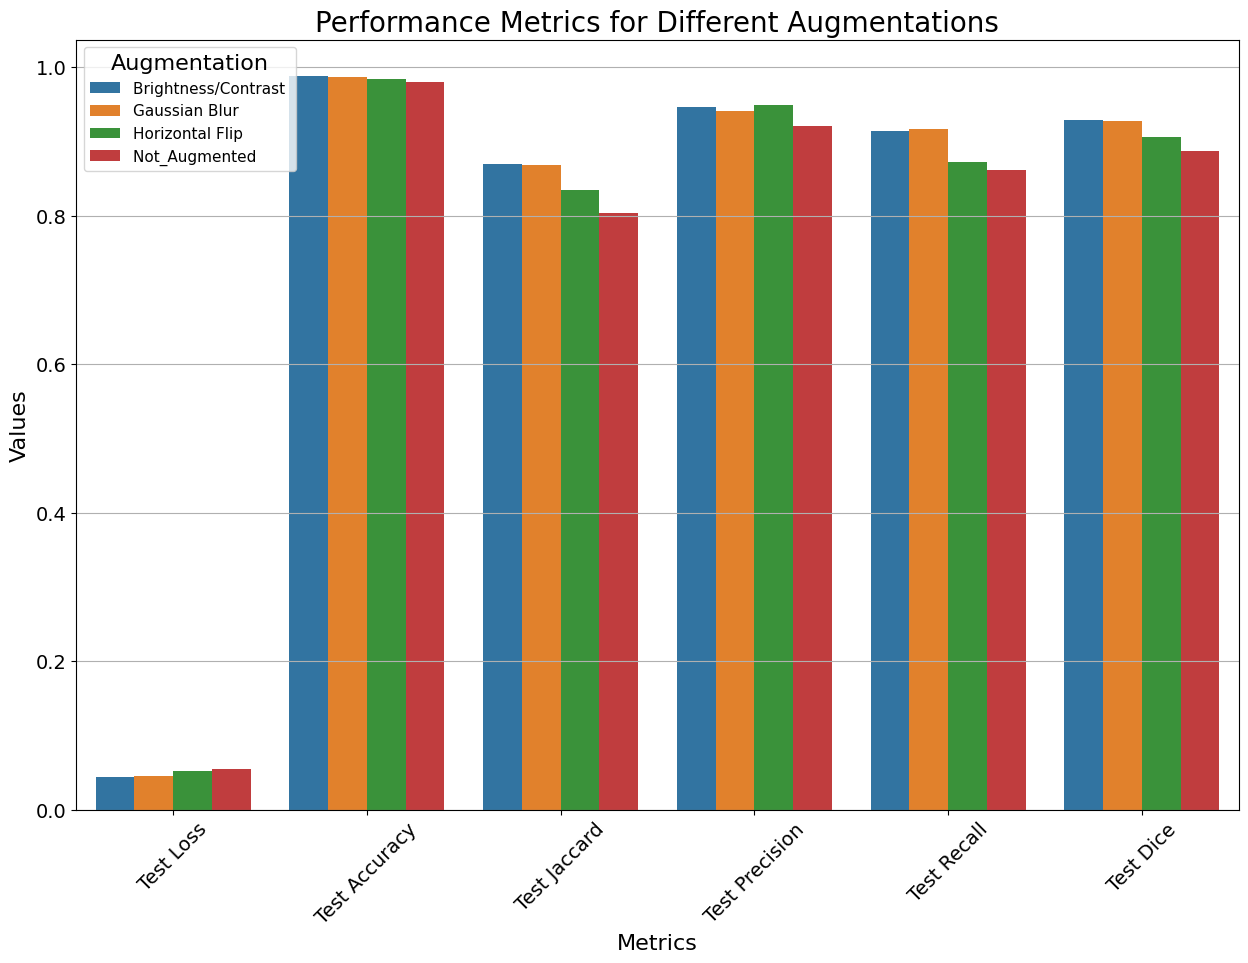

In [11]:
# Plotting bar chart for performance metrics
metrics_to_plot = ['Test Loss', 'Test Accuracy', 'Test Jaccard', 'Test Precision', 'Test Recall', 'Test Dice']
melted_df = average_metrics.melt(id_vars='Augmentation', value_vars=metrics_to_plot, var_name='Metric', value_name='Value')

plt.figure(figsize=(15, 10))
sns.barplot(data=melted_df, x='Metric', y='Value', hue='Augmentation', palette='tab10')
plt.xlabel('Metrics', fontsize=16)
plt.ylabel('Values', fontsize=16)
plt.title('Performance Metrics for Different Augmentations', fontsize=20)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Augmentation', fontsize=11, title_fontsize=16)
plt.grid(axis='y')
plt.show()

In [12]:
import os
import pandas as pd

# Load metrics from CSV file
csv_filepath = 'Output/Exp_2_Metrics.csv'
if os.path.exists(csv_filepath):
    metrics_df = pd.read_csv(csv_filepath)
    print(f"Metrics loaded from '{csv_filepath}'.")
else:
    print(f"No CSV file found at '{csv_filepath}'.")

# Strip leading and trailing spaces from column names
metrics_df.columns = metrics_df.columns.str.strip()

# Drop all train metrics (assuming 'Train' is part of the column names)
test_metrics_df = metrics_df.drop(columns=[col for col in metrics_df.columns if 'Train' in col])

# Calculate average metrics for each augmentation type, excluding the 'Epoch' column
average_metrics = test_metrics_df.drop(columns=['Epoch']).groupby("Augmentation").mean().reset_index()

# Add the highest epoch back to the average_metrics DataFrame
epoch_max = test_metrics_df.groupby("Augmentation")['Epoch'].max().reset_index()
average_metrics = average_metrics.merge(epoch_max, on="Augmentation")

# Reorder columns to have 'Epoch' as the second column
cols = list(average_metrics.columns)
cols.insert(1, cols.pop(cols.index('Epoch')))
average_metrics = average_metrics[cols]

# Sort results by Test Accuracy and select the top 4 results
sorted_results = average_metrics.sort_values(by="Test Accuracy", ascending=False)
top_4_results = sorted_results.head(4)

# Display the DataFrame
display(top_4_results)

Metrics loaded from 'Output/Exp_2_Metrics.csv'.


,Augmentation,Epoch,Test Loss,Test Accuracy,Test Jaccard,Test Precision,Test Recall,Test Dice
0,Brightness/Contrast,13,0.043579,0.987285,0.869597,0.946409,0.913447,0.928512
1,Gaussian Blur,4,0.045664,0.987113,0.868247,0.941105,0.916422,0.927506
2,Horizontal Flip,13,0.051981,0.984032,0.833861,0.948545,0.871735,0.905388
3,Not_Augmented,7,0.054853,0.980338,0.803487,0.919958,0.861196,0.887239


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


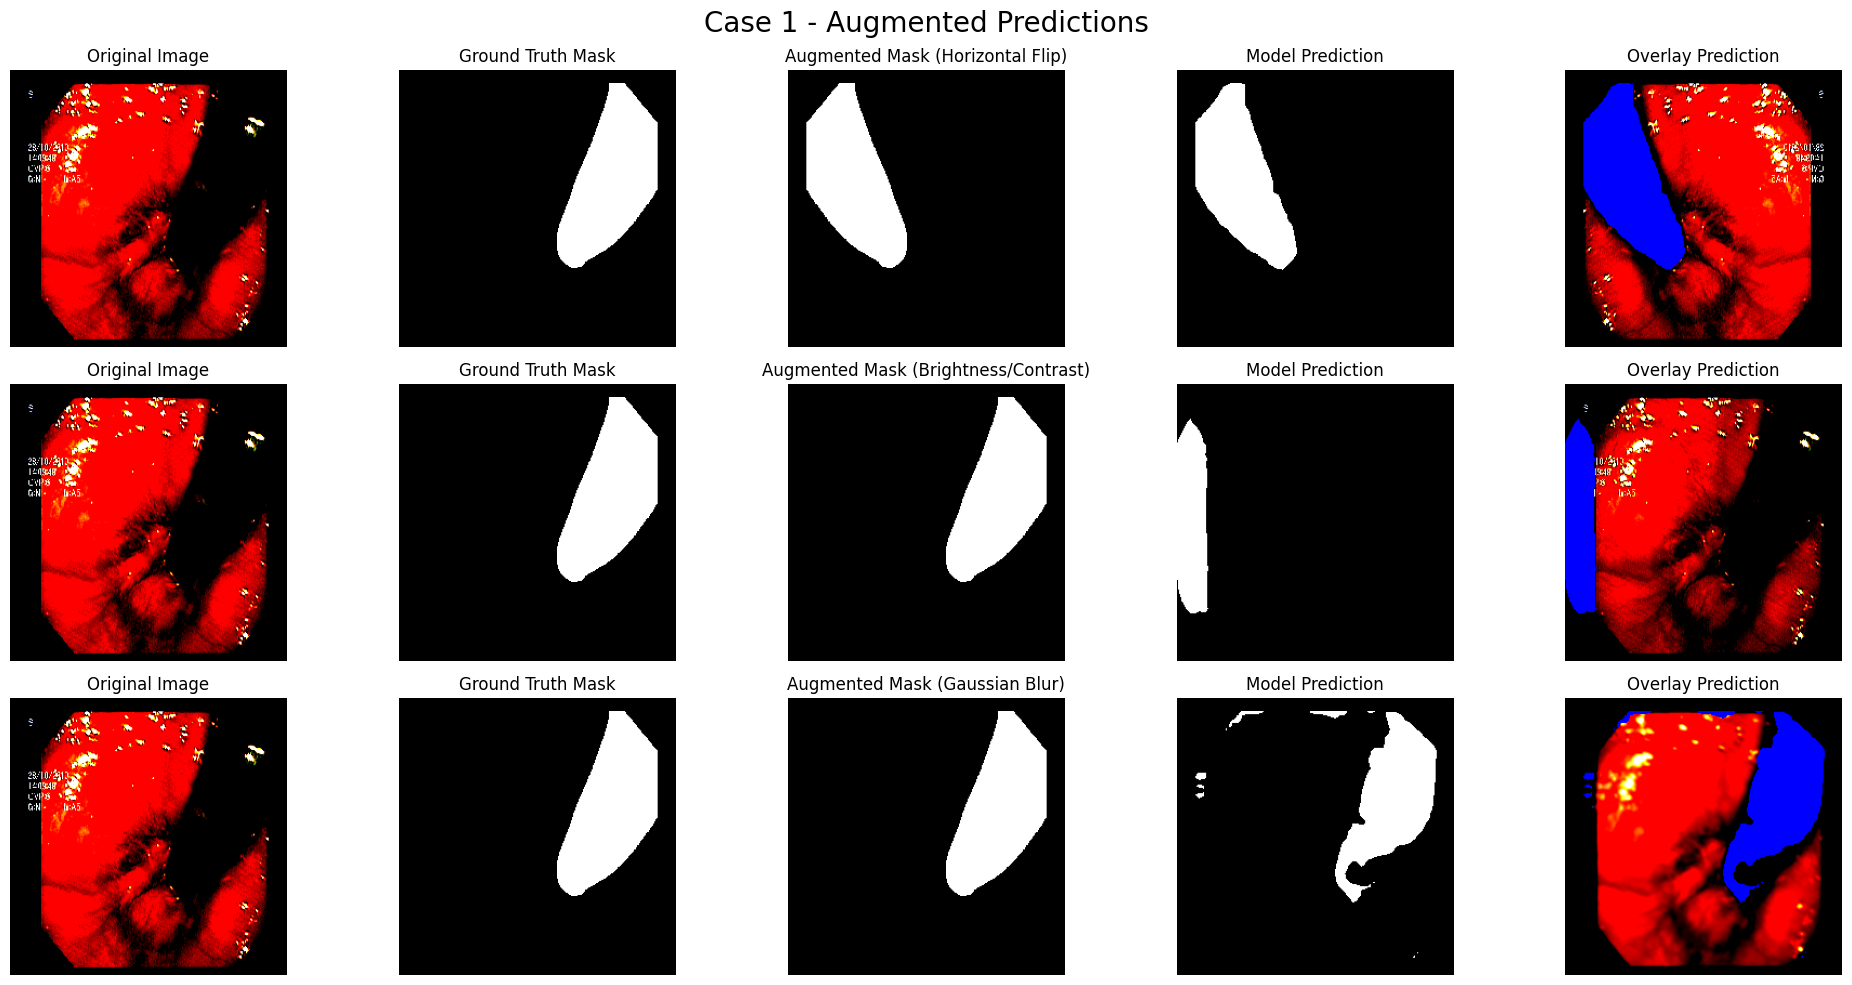

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


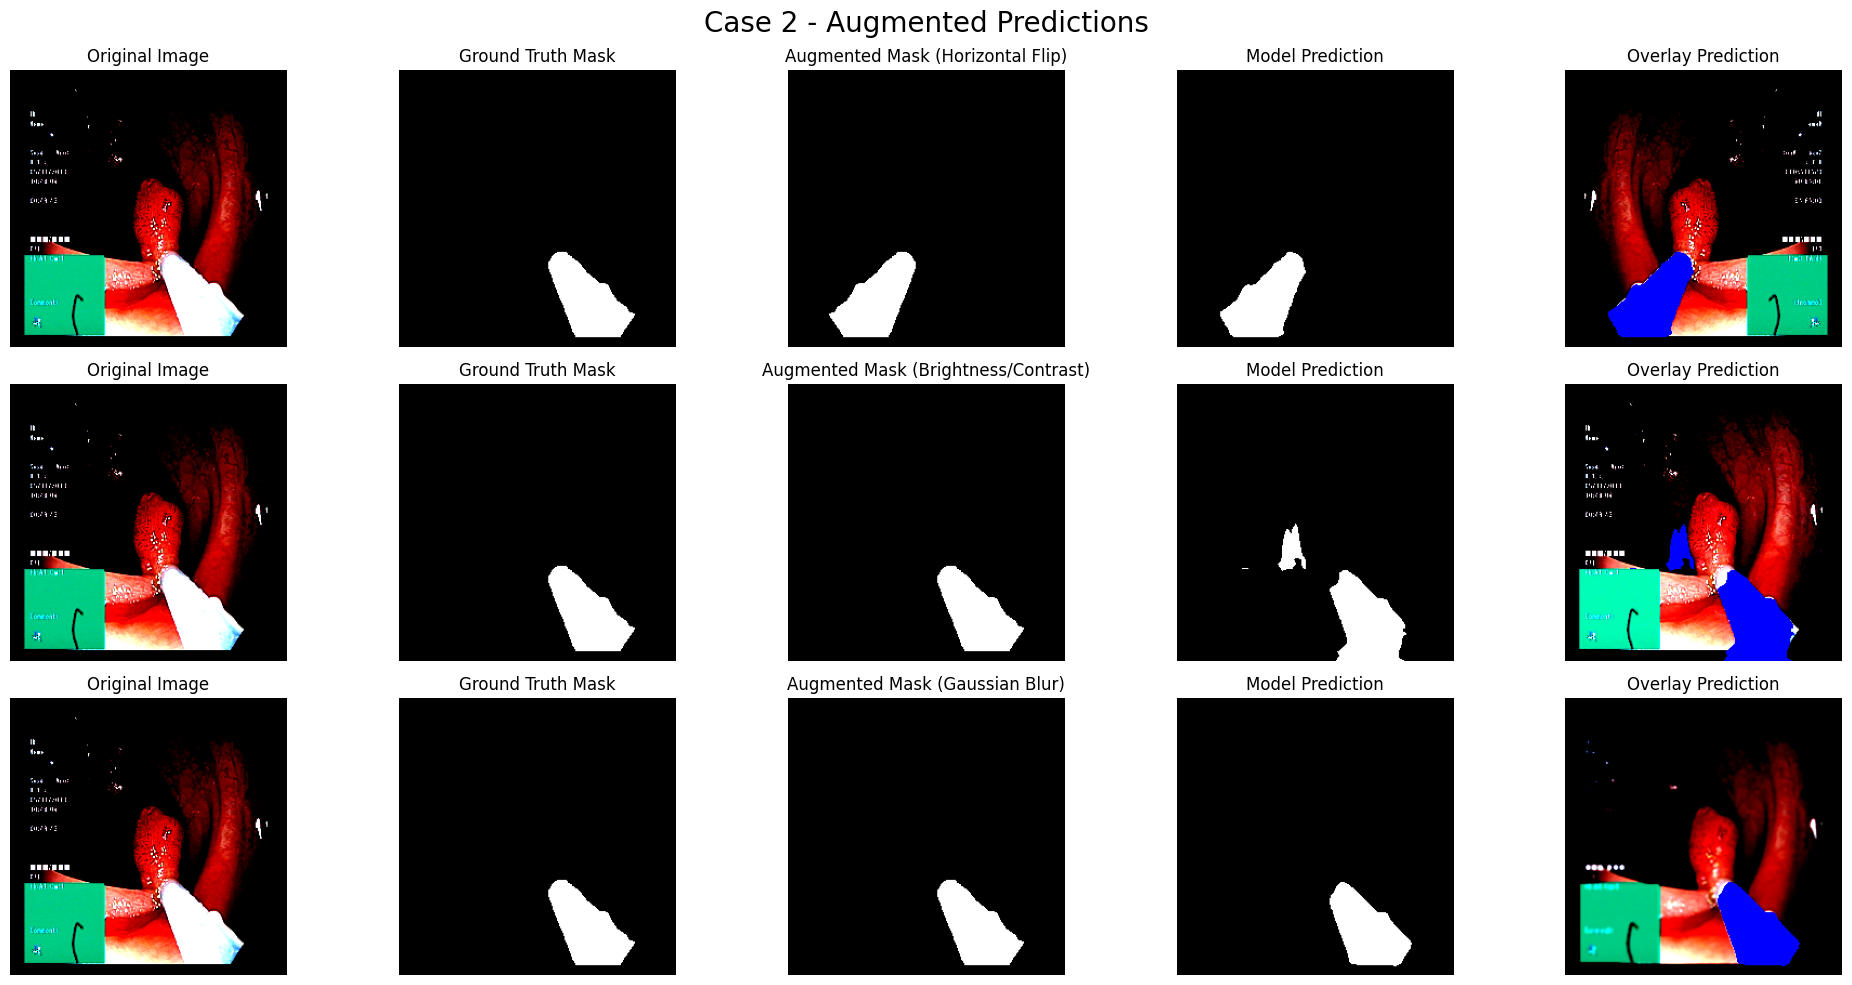

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


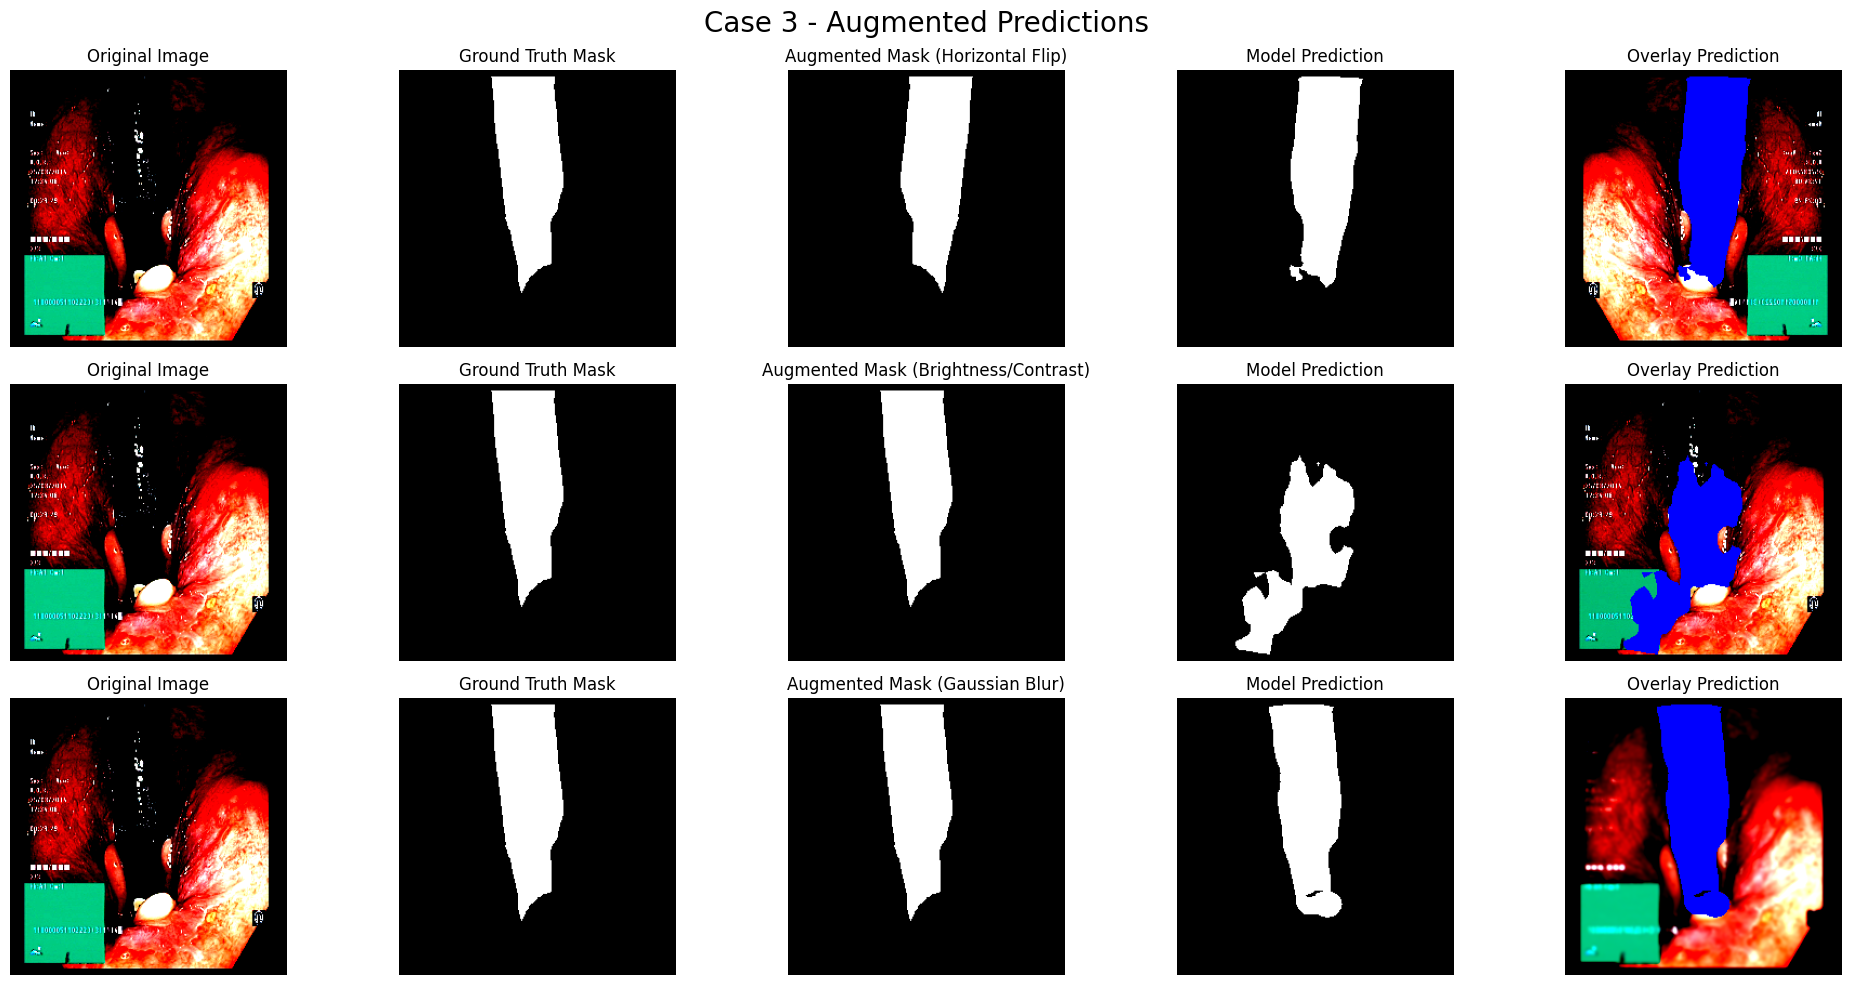

In [13]:
import matplotlib.pyplot as plt
import torch
from albumentations import Compose as AlbCompose, HorizontalFlip, RandomBrightnessContrast, GaussianBlur
import numpy as np

# Define and plot augmented cases
def plot_augmented_cases(model, dataset, num_cases=3):
    model.eval()
    
    augmentations = [
        ("Horizontal Flip", AlbCompose([HorizontalFlip(p=1.0)])),
        ("Brightness/Contrast", AlbCompose([RandomBrightnessContrast(p=1.0)])),
        ("Gaussian Blur", AlbCompose([GaussianBlur(blur_limit=(3, 7), p=1.0)]))
    ]
    
    with torch.no_grad():
        for case_idx in range(num_cases):
            image, mask = dataset[case_idx]
            image_np = image.permute(1, 2, 0).cpu().numpy()
            mask_np = mask.cpu().numpy()

            # Prepare a figure with rows for augmentations and 5 columns
            fig, axes = plt.subplots(len(augmentations), 5, figsize=(20, 10))
            fig.suptitle(f"Case {case_idx + 1} - Augmented Predictions", fontsize=20)

            for row_idx, (aug_name, aug_transform) in enumerate(augmentations):
                # Apply augmentation to both the image and mask
                augmented = aug_transform(image=image_np, mask=mask_np)
                augmented_image = augmented['image']
                augmented_mask = augmented['mask']

                # Convert augmented image back to tensor for model prediction
                augmented_tensor = torch.tensor(augmented_image).permute(2, 0, 1).unsqueeze(0).to(device)

                # Model prediction on augmented image
                output = model(augmented_tensor)
                prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

                # Overlay prediction on the augmented image
                overlay = np.copy(augmented_image)
                overlay[prediction == 1] = [0, 0, 255]  # Red overlay for predicted regions

                # Plot Original Image
                axes[row_idx, 0].imshow(image_np)
                axes[row_idx, 0].set_title("Original Image")
                axes[row_idx, 0].axis("off")

                # Plot Ground Truth Mask
                axes[row_idx, 1].imshow(mask_np, cmap="gray")
                axes[row_idx, 1].set_title("Ground Truth Mask")
                axes[row_idx, 1].axis("off")

                # Plot Augmented Ground Truth Mask
                axes[row_idx, 2].imshow(augmented_mask, cmap="gray")
                axes[row_idx, 2].set_title(f"Augmented Mask ({aug_name})")
                axes[row_idx, 2].axis("off")

                # Plot Model Prediction
                axes[row_idx, 3].imshow(prediction, cmap="gray")
                axes[row_idx, 3].set_title("Model Prediction")
                axes[row_idx, 3].axis("off")

                # Plot Overlay Prediction
                axes[row_idx, 4].imshow(overlay)
                axes[row_idx, 4].set_title("Overlay Prediction")
                axes[row_idx, 4].axis("off")
            
            plt.tight_layout()
            plt.show()


plot_augmented_cases(model, test_loader.dataset, num_cases=3)
